# Clase 6: Taller Práctico - Random Forest y Boosting

**Objetivos del Taller:**

1.  Aplicar los algoritmos de Random Forest y Gradient Boosting a un problema de clasificación.
2.  Entender cómo extraer y visualizar la importancia de las variables para interpretar los modelos.
3.  Comparar el rendimiento y las características de ambos métodos de ensamble.
4.  Experimentar con los hiperparámetros clave de cada modelo.

Utilizaremos el dataset `Heart`, que contiene datos de pacientes para predecir la presencia de enfermedades cardíacas.

In [51]:
# --- 1. Importación de Librerías --- 
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Clases de Scikit-Learn para modelos y evaluación
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score,precision_score, classification_report, confusion_matrix

# Librería del libro para cargar el dataset
from ISLP import load_data

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def draw_confusion_matrix(y_test, models):
    cols = 2
    rows = int(np.ceil(len(models) / cols))
    
    print(f'{rows} filas, {cols} columnas')

    fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows))  # más alto si hay más filas
    axes = np.array(axes).reshape(-1)  # aplana por si es 1D o 2D

    for i, (depth, data) in enumerate(models.items()):
        cm = confusion_matrix(y_test, data['pred'])

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'Matriz de Confusión - {data['model_name']} depth: {depth}')
        axes[i].set_xlabel('Predicho')
        axes[i].set_ylabel('Verdadero')

    # Ocultar subplots sobrantes (si hay más celdas que modelos)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


## 2. Carga y Exploración de Datos

Cargaremos el dataset `Heart` desde la librería `ISLP`. Este dataset es ideal para un problema de clasificación binaria.

In [5]:
import pandas as pd

# URL canónica del dataset Heart usado en el libro ISLP
url = 'https://www.statlearning.com/s/Heart.csv'

# Usamos pandas para leer el archivo CSV directamente desde la web
heart_df = pd.read_csv(url)
# A menudo, al cargar así, se crea una columna de índice no deseada. La eliminamos.
if 'Unnamed: 0' in heart_df.columns:
    heart_df = heart_df.drop('Unnamed: 0', axis=1)

# Verificamos que los datos se hayan cargado correctamente
print('Datos cargados exitosamente desde la URL:')
display(heart_df.head())

print('\\nInformación del Dataset:')
heart_df.info()

Datos cargados exitosamente desde la URL:


,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


\nInformación del Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        303 non-null    int64  
 1   Sex        303 non-null    int64  
 2   ChestPain  303 non-null    object 
 3   RestBP     303 non-null    int64  
 4   Chol       303 non-null    int64  
 5   Fbs        303 non-null    int64  
 6   RestECG    303 non-null    int64  
 7   MaxHR      303 non-null    int64  
 8   ExAng      303 non-null    int64  
 9   Oldpeak    303 non-null    float64
 10  Slope      303 non-null    int64  
 11  Ca         299 non-null    float64
 12  Thal       301 non-null    object 
 13  AHD        303 non-null    object 
dtypes: float64(2), int64(9), object(3)
memory usage: 33.3+ KB


In [6]:
for col_name in heart_df.select_dtypes(include=['object']).columns.tolist():
    print(f"Valores únicos en '{col_name}': {heart_df[col_name].unique()}")

Valores únicos en 'ChestPain': ['typical' 'asymptomatic' 'nonanginal' 'nontypical']
Valores únicos en 'Thal': ['fixed' 'normal' 'reversable' nan]
Valores únicos en 'AHD': ['No' 'Yes']


### 2.1. Preparación de los Datos

Para que los algoritmos de Scikit-learn funcionen correctamente, necesitamos realizar algunos pasos de preprocesamiento:

1.  **Limpieza de Nulos:** Verificar y eliminar filas con valores nulos para simplificar el análisis.
2.  **Codificación de Variables Categóricas:** Convertir columnas de texto (como `ChestPain`, `Thal`) en variables numéricas usando One-Hot Encoding.
3.  **Separación de Datos:** Dividir el dataset en un conjunto de características (`X`) y una variable objetivo (`y`).
4.  **División en Entrenamiento y Prueba:** Particionar los datos para entrenar el modelo y evaluarlo en datos no vistos.

In [16]:
# 1. Limpieza de Nulos
heart_df_clean = heart_df.dropna()

# 2. Separación de características (X) y objetivo (y)
X = heart_df_clean.drop('AHD', axis=1)
y = heart_df_clean['AHD']

#Columnas antes de one-hot
display(X.columns)
# 3. Codificación One-Hot para variables categóricas
# pd.get_dummies convierte columnas categóricas en 0s y 1s
X_encoded = pd.get_dummies(X, drop_first=True)

print('Columnas después de la codificación One-Hot:')
print(X_encoded.columns)

# 4. División en conjuntos de entrenamiento y prueba (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f'\nTamaño del set de entrenamiento: {X_train.shape[0]} muestras')
print(f'Tamaño del set de prueba: {X_test.shape[0]} muestras')

Index(['Age', 'Sex', 'ChestPain', 'RestBP', 'Chol', 'Fbs', 'RestECG', 'MaxHR',
       'ExAng', 'Oldpeak', 'Slope', 'Ca', 'Thal'],
      dtype='object')

Columnas después de la codificación One-Hot:
Index(['Age', 'Sex', 'RestBP', 'Chol', 'Fbs', 'RestECG', 'MaxHR', 'ExAng',
       'Oldpeak', 'Slope', 'Ca', 'ChestPain_nonanginal',
       'ChestPain_nontypical', 'ChestPain_typical', 'Thal_normal',
       'Thal_reversable'],
      dtype='object')

Tamaño del set de entrenamiento: 237 muestras
Tamaño del set de prueba: 60 muestras


## 3. Random Forest

Ahora, entrenaremos nuestro primer modelo de ensamble. Un `RandomForestClassifier` es una colección de árboles de decisión entrenados en subconjuntos de datos y características, cuyas predicciones se combinan para obtener un resultado final más robusto.

In [17]:
# Instanciar el clasificador de Random Forest
# n_estimators: número de árboles en el bosque.
# random_state: para reproducibilidad de los resultados.
rf_model = RandomForestClassifier(n_estimators=100, random_state=100, oob_score=True)

# Entrenar el modelo con los datos de entrenamiento
rf_model.fit(X_train, y_train)

# Realizar predicciones sobre el conjunto de prueba
y_pred_rf = rf_model.predict(X_test)

# Evaluar el rendimiento
print("--- Evaluación de Random Forest ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Error OOB (Out-of-Bag): {1 - rf_model.oob_score_:.4f}") # Error OOB
print(f"Accuracy OOB: {rf_model.oob_score_:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

--- Evaluación de Random Forest ---
Accuracy: 0.8167
Error OOB (Out-of-Bag): 0.2025
Accuracy OOB: 0.7975

Classification Report:
              precision    recall  f1-score   support

          No       0.80      0.88      0.84        32
         Yes       0.84      0.75      0.79        28

    accuracy                           0.82        60
   macro avg       0.82      0.81      0.81        60
weighted avg       0.82      0.82      0.82        60



### 3.1. Importancia de Variables
Una de las grandes ventajas de Random Forest es que nos permite medir qué tan importante fue cada variable para la predicción. Lo visualizaremos para entender mejor qué factores influyen más en el diagnóstico.

In [18]:
# Extraer la importancia de las variables
importances = rf_model.feature_importances_
feature_names = X_encoded.columns

# Crear un DataFrame para facilitar la visualización
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualizar con Plotly Express
fig = px.bar(
    importance_df.head(15), 
    x='Importance', 
    y='Feature', 
    orientation='h', 
    title='Importancia de las Variables (Random Forest)',
    labels={'Feature': 'Variable', 'Importance': 'Importancia'}
)
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

In [19]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Mapeo de colores
color_map = {"Yes": "blue", "No": "red"}
ca_values = [0, 1, 2, 3]
titles = [f'Ca = {val}' for val in ca_values]
positions = [(1, 1), (1, 2), (2, 1), (2, 2)]

fig = make_subplots(rows=2, cols=2, subplot_titles=titles)

for idx, ca_val in enumerate(ca_values):
    row, col = positions[idx]
    df_plot = heart_df_clean[heart_df_clean["Ca"] == ca_val]
    show_legend = (idx == 0)
    for ahd_val in ["Yes", "No"]:
        df_class = df_plot[df_plot["AHD"] == ahd_val]
        fig.add_trace(
            go.Scatter(x=df_class["Oldpeak"], y=df_class["MaxHR"], mode="markers",
                marker=dict(color=color_map[ahd_val]), name=ahd_val, showlegend=show_legend,
            ), row=row, col=col
        )
    show_legend = False

# Set axis titles for all subplots
for r in [1, 2]:
    for c in [1, 2]:
        fig.update_xaxes(title_text="Oldpeak", row=r, col=c)
        fig.update_yaxes(title_text="MaxHR", row=r, col=c)


fig.update_layout(
    height=800,
    width=900,
    title_text="Scatter Plots by Ca Value",
    legend=dict(title="AHD")
)
fig.show()

### ❔ Preguntas para Reflexionar (Random Forest)

1.  **Experimenta con `n_estimators`**: ¿Cómo cambia el rendimiento y el error OOB si usas 10, 50, 200, o 500 árboles? ¿Hay un punto a partir del cual el rendimiento deja de mejorar significativamente?
2.  **Analiza `max_features`**: Prueba cambiar este hiperparámetro. El valor por defecto es `sqrt(p)`. ¿Qué ocurre si lo ajustas a `None` (equivalente a Bagging) o a un número muy pequeño como `2`?

## 4. Gradient Boosting

Ahora, probaremos con Gradient Boosting. A diferencia de Random Forest, este método construye los árboles de forma secuencial, donde cada nuevo árbol intenta corregir los errores de los anteriores. Es conocido por su alto rendimiento, aunque puede ser más sensible a los hiperparámetros.

In [20]:
# Instanciar el clasificador de Gradient Boosting
# n_estimators: número de árboles secuenciales.
# learning_rate: factor de contracción (shrinkage) para cada árbol.
# max_depth: profundidad máxima de cada árbol (suelen ser superficiales).
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Entrenar el modelo
gb_model.fit(X_train, y_train)

# Realizar predicciones
y_pred_gb = gb_model.predict(X_test)

# Evaluar el rendimiento
print("--- Evaluación de Gradient Boosting ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb))

--- Evaluación de Gradient Boosting ---
Accuracy: 0.8500

Classification Report:
              precision    recall  f1-score   support

          No       0.87      0.84      0.86        32
         Yes       0.83      0.86      0.84        28

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60



### 4.1. Comparación de Matrices de Confusión

La precisión general es útil, pero una matriz de confusión nos da más detalles sobre el tipo de errores que comete cada modelo (Falsos Positivos vs. Falsos Negativos), lo cual es crucial en problemas médicos.

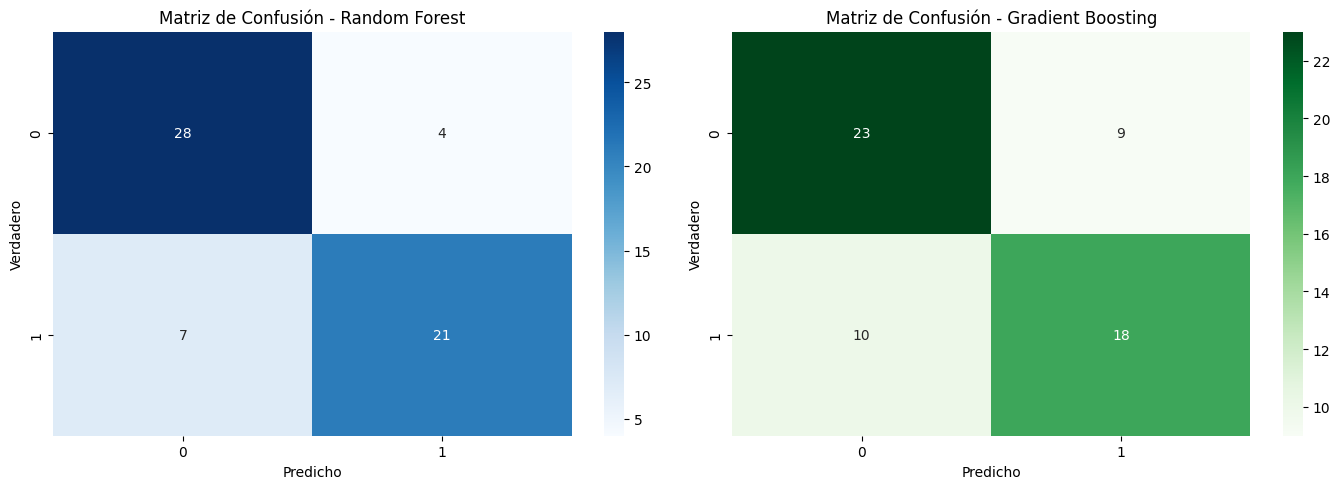

In [35]:
# Calcular matrices de confusión
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_gb = confusion_matrix(y_test, y_pred_gb)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Matriz de Confusión - Random Forest')
axes[0].set_xlabel('Predicho')
axes[0].set_ylabel('Verdadero')

sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Matriz de Confusión - Gradient Boosting')
axes[1].set_xlabel('Predicho')
axes[1].set_ylabel('Verdadero')

plt.tight_layout()
plt.show()

In [22]:
import pandas as pd
import plotly.express as px
from sklearn.metrics import roc_curve, auc

# Calcular ROC y AUC para ambos modelos
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test.map({"No": 0, "Yes": 1}), rf_model.predict_proba(X_test)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test.map({"No": 0, "Yes": 1}), gb_model.predict_proba(X_test)[:, 1])
roc_auc_gb = auc(fpr_gb, tpr_gb)

roc_df = pd.DataFrame({
    "FPR": list(fpr_rf) + list(fpr_gb), "TPR": list(tpr_rf) + list(tpr_gb),
    "Threshold": list(thresholds_rf) + list(thresholds_gb),
    "Model": (["Random Forest"] * len(fpr_rf)) + (["Gradient Boosting"] * len(fpr_gb))
})
fig = px.line(
    roc_df, x="FPR", y="TPR", color="Model", line_dash="Model", title="ROC Curves",
    labels={"FPR": "False Positive Rate (FPR)", "TPR": "True Positive Rate (TPR)"}, hover_data=["Threshold"]
)
fig.add_shape(
    type="line", x0=0, y0=0, x1=1, y1=1,
    line=dict(color="red", dash="dash")
)
fig.for_each_trace(
    lambda t: t.update(
        name=f"{t.name} (AUC = {roc_auc_rf:.2f})" if "Random Forest" in t.name else f"{t.name} (AUC = {roc_auc_gb:.2f})"
    )
)
fig.update_layout(
    width=800, height=500,legend=dict(
        x=0.98, y=0.02, xanchor="right", yanchor="bottom",
        bgcolor="rgba(255,255,255,0.7)", bordercolor="black", borderwidth=1)
)
fig.show()

### ❔ Preguntas para Reflexionar (Gradient Boosting)

1.  **El trade-off `learning_rate` y `n_estimators`**: Reduce el `learning_rate` a `0.01`. ¿Cómo afecta esto a la precisión? ¿Necesitas más `n_estimators` para compensar? ¿Qué pasa si aumentas el `learning_rate` a `0.5`?
2.  **Importancia de `max_depth`**: En Boosting, los árboles suelen ser superficiales. Prueba con `max_depth=1` (stumps). ¿Cómo se compara el resultado con `max_depth=3`?
3.  **Análisis de errores**: Basándote en las matrices de confusión, ¿qué modelo es mejor para minimizar los **falsos negativos** (predecir 'No' cuando en realidad es 'Sí')? ¿Por qué esto podría ser lo más importante en un contexto de diagnóstico médico?

## 5. Ejercicios Adicionales

¡Es tu turno de explorar! A continuación, se proponen 10 ejercicios para profundizar en los conceptos vistos y experimentar por tu cuenta.

1.  **Optimización de Profundidad:** Para ambos modelos (RF y GB), varía el hiperparámetro `max_depth` (ej. 2, 3, 5, 10) y analiza cómo afecta a la precisión en el conjunto de prueba. ¿Observas sobreajuste en alguno de los modelos cuando la profundidad es muy alta?

2.  **Búsqueda de Hiperparámetros con `GridSearchCV`:** Utiliza `GridSearchCV` de Scikit-learn para encontrar la combinación óptima de hiperparámetros para el `RandomForestClassifier`. Busca sobre `n_estimators`, `max_depth` y `max_features`.

3.  **Visualizar el Error OOB:** En el modelo de Random Forest, el atributo `oob_score_` se calcula sobre el ensamble final. Para visualizar la curva, entrena varios modelos con diferente `n_estimators` (de 10 a 200, por ejemplo) y grafica el error OOB (`1 - oob_score_`) en función del número de árboles.

4.  **Probar un Dataset Diferente:** Carga el dataset de cáncer de mama de Scikit-learn (`from sklearn.datasets import load_breast_cancer`). Aplica tanto Random Forest como Gradient Boosting y compara sus resultados en este nuevo problema.

5.  **Implementar `AdaBoost`:** Scikit-learn también tiene `AdaBoostClassifier`. Impleméntalo en el dataset `Heart` y compara su rendimiento y sus hiperparámetros con los de `GradientBoostingClassifier`.

6.  **Curva de Aprendizaje en Boosting:** Para el modelo de Gradient Boosting, puedes acceder al error en cada etapa de la construcción secuencial. Utiliza el método `staged_predict()` para obtener las predicciones en cada iteración y grafica el error de prueba en función del número de árboles. ¿Observas un punto donde el error deja de bajar y empieza a subir (sobreajuste)?

7.  **Importancia de Variables en Boosting:** Al igual que con Random Forest, los modelos de Gradient Boosting también tienen el atributo `.feature_importances_`. Extrae y visualiza la importancia de las variables para el modelo `gb_model`. ¿Coinciden las variables más importantes con las de Random Forest?

8.  **Análisis de Probabilidades:** En lugar de predecir la clase directamente (`.predict()`), utiliza `.predict_proba()` para obtener las probabilidades. ¿Cómo podrías ajustar el umbral de decisión (por defecto es 0.5) para, por ejemplo, ser más sensible y capturar más casos positivos, aunque aumenten los falsos positivos?

9.  **Investigar XGBoost:** Lee la documentación de la popular librería `xgboost`. Instálala (`pip install xgboost`) e impleméntala en este mismo problema. Compara su rendimiento y velocidad con el `GradientBoostingClassifier` de Scikit-learn.

10. **Conclusión Final:** Escribe un párrafo en una celda de Markdown resumiendo tus hallazgos. ¿Qué modelo funcionó mejor para este problema? ¿Cuál recomendarías para un despliegue en producción y por qué, considerando la precisión, la interpretabilidad y el coste computacional?

# 1

--- Evaluación de Gradient Boosting para depth: 2---
Accuracy: 0.8667

Classification Report:
              precision    recall  f1-score   support

          No       0.88      0.88      0.88        32
         Yes       0.86      0.86      0.86        28

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60

--- Evaluación de Gradient Boosting para depth: 3---
Accuracy: 0.8500

Classification Report:
              precision    recall  f1-score   support

          No       0.87      0.84      0.86        32
         Yes       0.83      0.86      0.84        28

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60

--- Evaluación de Gradient Boosting para depth: 5---
Accuracy: 0.7667

Classification Report:
              precision    recall  f1-score   support

         

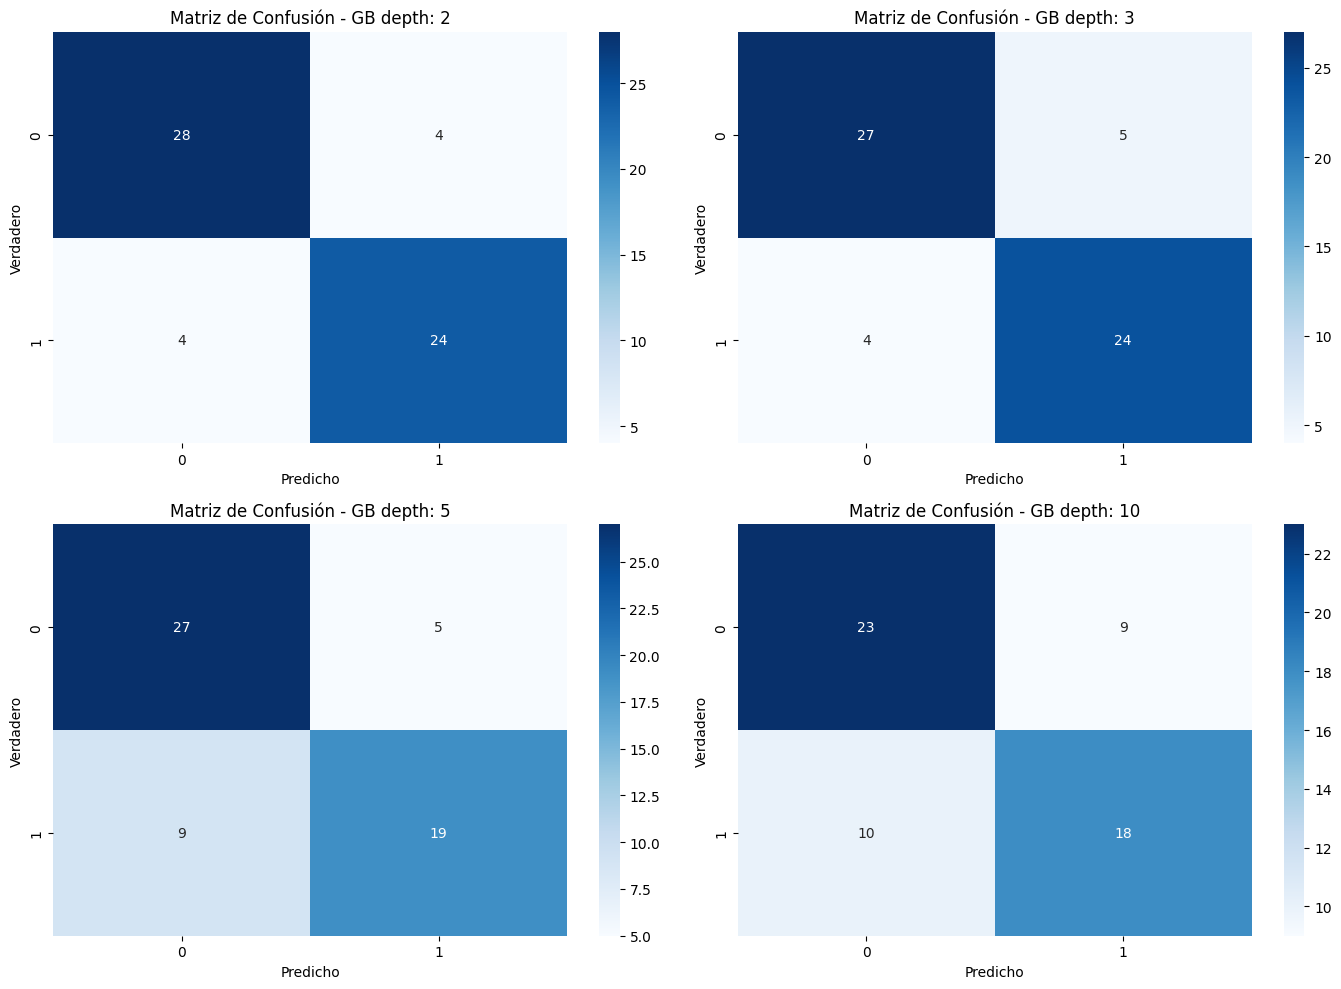

--- Evaluación de Random Forest ---
Accuracy: 0.8333
Error OOB (Out-of-Bag): 0.1983
Accuracy OOB: 0.8017

Classification Report:
              precision    recall  f1-score   support

          No       0.81      0.91      0.85        32
         Yes       0.88      0.75      0.81        28

    accuracy                           0.83        60
   macro avg       0.84      0.83      0.83        60
weighted avg       0.84      0.83      0.83        60

--- Evaluación de Random Forest ---
Accuracy: 0.8500
Error OOB (Out-of-Bag): 0.2068
Accuracy OOB: 0.7932

Classification Report:
              precision    recall  f1-score   support

          No       0.83      0.91      0.87        32
         Yes       0.88      0.79      0.83        28

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60

--- Evaluación de Random Forest ---
Accuracy: 0.8500
Error OOB (Out-of-Bag): 0.2110
Accu

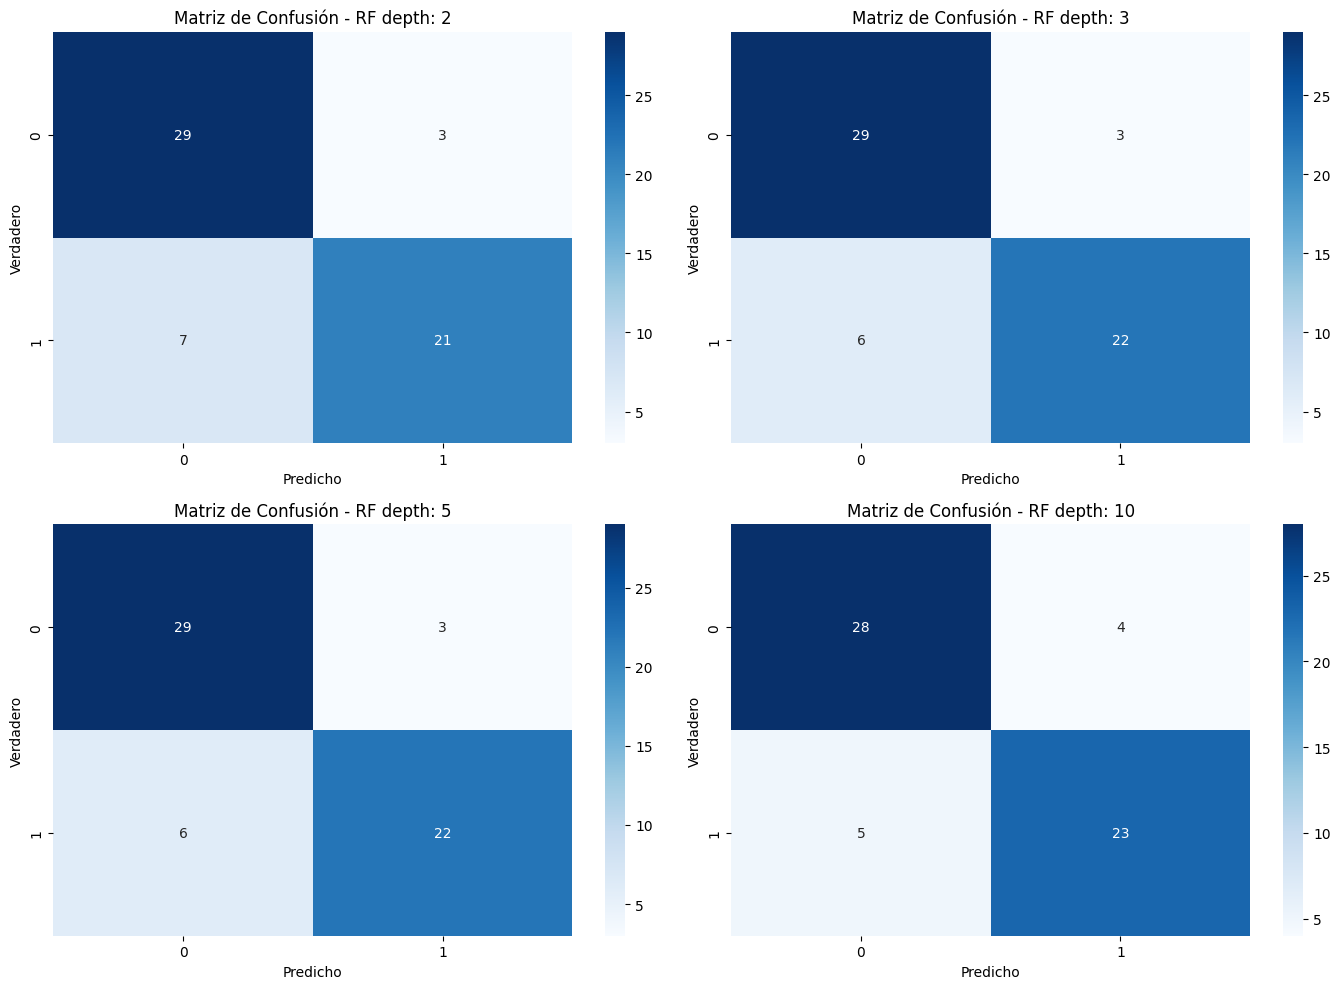

In [102]:
depths=[2,3,5,10]
gb_models={}
for depth in depths:
    gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=depth, random_state=42)
    gb_model.fit(X_train, y_train)
    y_pred_gb = gb_model.predict(X_test)
    gb_model_data={'model_name': 'GB',
                   'model': gb_model,
                   'pred': y_pred_gb,
                   'accuracy':accuracy_score(y_test, y_pred_gb),
                   'precision': precision_score(y_test,y_pred_gb,pos_label='Yes')}
    gb_models[depth]=gb_model_data
    # Evaluar el rendimiento
    print(f"--- Evaluación de Gradient Boosting para depth: {depth}---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_gb):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_gb))
        
draw_confusion_matrix(y_test,gb_models)


rf_models={}
for depth in depths:
    rf_model = RandomForestClassifier(n_estimators=100, random_state=100, oob_score=True,max_depth=depth)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    rf_model_data={'model_name': 'RF',
                   'model': rf_model,
                   'pred': y_pred_rf,
                   'accuracy':accuracy_score(y_test, y_pred_rf),
                   'precision': precision_score(y_test,y_pred_rf,pos_label='Yes')}
    rf_models[depth]=rf_model_data
   # Evaluar el rendimiento
    print("--- Evaluación de Random Forest ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
    print(f"Error OOB (Out-of-Bag): {1 - rf_model.oob_score_:.4f}") # Error OOB
    print(f"Accuracy OOB: {rf_model.oob_score_:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_rf))
        
draw_confusion_matrix(y_test,rf_models)




En los modelos de RF como se ve que el 1-OOB aumenta entonces hay mas errores, por lo tanto puede haber overfitting. 
En el caso de boosting no es claro si bien el modelo empeora hay que probarlo con el trainning set para estar seguro que el modelo es mejor que el anterior en términos de perfomance con el entrenamiento